Import main libraties.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
#from sklearn.decomposition import PCA

Import functions.

In [4]:
def data_info(table):
    table.info(memory_usage='deep')
    display(table.head(5))

def unique_check(table,column):
    max_value = table[column].max()
    min_value = table[column].min()
    display(max_value,min_value)
    display(table[column].value_counts())
    
def corr_info(table):
    display(table.corr())
    heatmap0 = sns.heatmap(table.corr(), 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': 1, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})
    plt.show()
    plt.figure(figsize=(18,7))
    
def outlier_treatment(table,column):
    sorted(table[column])
    Q1,Q3 = np.percentile(table[column], [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    number_of_outliers = ((table[column] < lower_range) | (table[column] > upper_range)).sum()
    percentage_of_outliers = "{:.3%}".format(number_of_outliers/len(table[column]))
    stats = []
    stats.append([lower_range,upper_range,number_of_outliers,percentage_of_outliers])
    stats_df = pd.DataFrame(stats,columns = ['lower_range','upper_range','number_of_outliers','percentage_of_outliers'])
    display(stats_df)
    return 

def plot_feature_importance(importance,names,model_type): 
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [5]:
df_open = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/datasets/5_autos.csv')
data_info(df_open)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df_open['RegistrationYear'] = df_open['RegistrationYear'].astype('uint16')
df_open['Power'] = df_open['Power'].astype('uint16')
df_open['Kilometer'] = df_open['Kilometer'].astype('uint32')
df_open['RegistrationMonth'] = df_open['RegistrationMonth'].astype('uint8')
df_open['Price'] = df_open['Price'].astype('uint32')

In [7]:
df_open['VehicleType'] = df_open['VehicleType'].replace(np.NaN,'other') #other
df_open['Gearbox'] = df_open['Gearbox'].replace(np.NaN,'unknown') #unknown
df_open['Model'] = df_open['Model'].replace(np.NaN,'other')
df_open['FuelType'] = df_open['FuelType'].replace(np.NaN,'other')
df_open['NotRepaired'] = df_open['NotRepaired'].replace(np.NaN,'unknown')

In [8]:
outlier_treatment(df_open,'Power')
outlier_treatment(df_open,'Price')
outlier_treatment(df_open,'RegistrationYear')
outlier_treatment(df_open,'Kilometer')

,lower_range,upper_range,number_of_outliers,percentage_of_outliers
0,-42.0,254.0,7340,2.071%


,lower_range,upper_range,number_of_outliers,percentage_of_outliers
0,-6975.0,14425.0,18979,5.356%


,lower_range,upper_range,number_of_outliers,percentage_of_outliers
0,1985.5,2021.5,6309,1.780%


,lower_range,upper_range,number_of_outliers,percentage_of_outliers
0,87500.0,187500.0,53257,15.029%


In [9]:
df_open['Power'][df_open['Power']>1479] = 0
df_open['Power'][df_open['Power']<0] = 0
df_open['Power'] = df_open['Power'].replace(0,df_open['Power'].median())
df0 = df_open.loc[(df_open['Price']>0)].copy().reset_index(drop=True)
df1 = df0.loc[(df_open['RegistrationYear']<2016)&(df_open['RegistrationYear']>1939)].reset_index(drop=True) 

In [10]:
columns_to_delete = ['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df_before_ord = df1.drop(columns_to_delete, axis=1)
df_before_ord = df_before_ord.drop_duplicates()

In [11]:
data_info(df_before_ord)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296850 entries, 0 to 319971
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              296850 non-null  uint32 
 1   VehicleType        296850 non-null  object 
 2   RegistrationYear   296850 non-null  uint16 
 3   Gearbox            296850 non-null  object 
 4   Power              296850 non-null  float64
 5   Model              296850 non-null  object 
 6   Kilometer          296850 non-null  uint32 
 7   RegistrationMonth  296850 non-null  uint8  
 8   FuelType           296850 non-null  object 
 9   Brand              296850 non-null  object 
 10  NotRepaired        296850 non-null  object 
dtypes: float64(1), object(6), uint16(1), uint32(2), uint8(1)
memory usage: 113.5 MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,other,1993,manual,105.0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


In [12]:
cutt = len(df_open) - len(df_before_ord)
percent_cutt = cutt/len(df_open)
display(percent_cutt)

0.16231385928227357

Let's look upon correlation matrix.

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.031108,0.454278,-0.345170,0.097251
RegistrationYear,0.031108,1.000000,0.003778,-0.054386,-0.011331
Power,0.454278,0.003778,1.000000,0.092122,0.047935
Kilometer,-0.345170,-0.054386,0.092122,1.000000,0.004967
RegistrationMonth,0.097251,-0.011331,0.047935,0.004967,1.000000


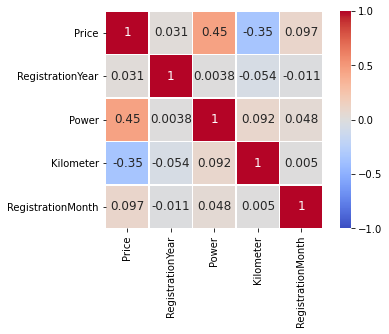

<Figure size 1296x504 with 0 Axes>

In [13]:
corr_info(df_before_ord)

Let's transform data.

In [14]:
encoder = OrdinalEncoder()
encoder.fit(df_before_ord) 
df = pd.DataFrame(encoder.fit_transform(df_before_ord),columns=df_before_ord.columns)

In [15]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296850 entries, 0 to 296849
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              296850 non-null  float64
 1   VehicleType        296850 non-null  float64
 2   RegistrationYear   296850 non-null  float64
 3   Gearbox            296850 non-null  float64
 4   Power              296850 non-null  float64
 5   Model              296850 non-null  float64
 6   Kilometer          296850 non-null  float64
 7   RegistrationMonth  296850 non-null  float64
 8   FuelType           296850 non-null  float64
 9   Brand              296850 non-null  float64
 10  NotRepaired        296850 non-null  float64
dtypes: float64(11)
memory usage: 24.9 MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,250.0,3.0,79.0,1.0,104.0,116.0,12.0,0.0,6.0,38.0,1.0
1,3505.0,2.0,97.0,1.0,189.0,166.0,11.0,5.0,2.0,1.0,2.0
2,2530.0,6.0,90.0,0.0,162.0,117.0,11.0,8.0,2.0,14.0,1.0
3,686.0,5.0,87.0,1.0,74.0,116.0,12.0,6.0,6.0,38.0,0.0
4,1306.0,5.0,94.0,1.0,68.0,101.0,9.0,7.0,2.0,31.0,0.0


In [16]:
target = df['Price']
features = df.drop('Price', axis=1)
display(target)
display(features)

0          250.0
1         3505.0
2         2530.0
3          686.0
4         1306.0
           ...  
296845    1703.0
296846    1200.0
296847     558.0
296848    2433.0
296849    1248.0
Name: Price, Length: 296850, dtype: float64

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,3.0,79.0,1.0,104.0,116.0,12.0,0.0,6.0,38.0,1.0
1,2.0,97.0,1.0,189.0,166.0,11.0,5.0,2.0,1.0,2.0
2,6.0,90.0,0.0,162.0,117.0,11.0,8.0,2.0,14.0,1.0
3,5.0,87.0,1.0,74.0,116.0,12.0,6.0,6.0,38.0,0.0
4,5.0,94.0,1.0,68.0,101.0,9.0,7.0,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...
296845,3.0,102.0,0.0,149.0,4.0,12.0,12.0,5.0,0.0,0.0
296846,4.0,90.0,1.0,224.0,140.0,12.0,5.0,6.0,30.0,2.0
296847,1.0,86.0,0.0,100.0,106.0,11.0,3.0,6.0,32.0,0.0
296848,0.0,82.0,1.0,101.0,224.0,12.0,3.0,2.0,38.0,0.0


In [17]:
train_features_non_scaled, other_features, target_train, other_target = train_test_split(
    features, target, test_size=0.3, random_state=123455)

valid_features_non_scaled, test_features_non_scaled, target_valid, target_test = train_test_split(
    other_features, other_target, test_size=0.5, random_state=123455)

In [18]:
scaler = StandardScaler()
scaler.fit(train_features_non_scaled)
features_train = scaler.transform(train_features_non_scaled)
features_valid = scaler.transform(valid_features_non_scaled)
features_test = scaler.transform(test_features_non_scaled)
target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(207795, 10)

(207795,)

(44527, 10)

(44527,)

(44528, 10)

(44528,)

## Logistic regression

In [19]:
st_time_lin = time.time()
model_lin = LinearRegression()
time_lin = time.time() - st_time_lin
#display(predictions_lin)
#display(target_valid)

In [20]:
model_lin.fit(features_train, target_train)

predictions_lin = model_lin.predict(features_valid)
predictions_lin = pd.Series(predictions_lin)
mse_lin = mean_squared_error(target_valid, predictions_lin)
rmse_lin = mse_lin ** 0.5
r2_lin = r2_score(target_valid, predictions_lin)

predictions_test_lin = model_lin.predict(features_test)
predictions_test_lin = pd.Series(predictions_test_lin)
mse_lin_test = mean_squared_error(target_test, predictions_test_lin)
rmse_lin_test = mse_lin_test ** 0.5

In [21]:
stats_lin = {'stats': ['r2','rmse_valid','rmse_test','time_learn','time_predict'],
        'values': [r2_lin,rmse_lin,rmse_lin_test,time_lin,time_lin]
        }
stats_lin = pd.DataFrame(stats_lin).set_index('stats')

In [22]:
display(stats_lin)

,values
stats,
r2,0.556693
rmse_valid,617.026919
rmse_test,624.883177
time_learn,0.000000
time_predict,0.000000


## Random forest

In [23]:
st_time_forest = time.time()
model_forest = RandomForestRegressor(random_state=123455)
param_dist_forest = {
    'n_estimators': range(1,101,20),
    'max_depth': range(1,21,5),
}
grid_search_forest = GridSearchCV(estimator = model_forest, param_grid = param_dist_forest, cv = 3,
                                  n_jobs = -1, verbose = 2)
grid_search_forest.fit(features_train, target_train)
time_forest = time.time() - st_time_forest

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [24]:
display(time_forest)

79.6868155002594

In [25]:
grid_search_forest.best_estimator_

RandomForestRegressor(max_depth=16, n_estimators=81, random_state=123455)

In [26]:
model_forest_final = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=81,
                      n_jobs=None, oob_score=False, random_state=123455,
                      verbose=0, warm_start=False)

In [27]:
st_time_forest_predict = time.time()
model_forest_final.fit(features_train, target_train)

predictions_forest = model_forest_final.predict(features_valid)
predictions_forest = pd.Series(predictions_forest)
time_forest_predict = time.time() - st_time_forest_predict

mse_forest = mean_squared_error(target_valid, predictions_forest)
rmse_forest = mse_forest ** 0.5
r2_forest = r2_score(target_valid, predictions_forest)

predictions_test_forest = model_forest_final.predict(features_test)
predictions_test_forest = pd.Series(predictions_test_forest)
mse_forest_test = mean_squared_error(target_test, predictions_test_forest)
rmse_forest_test = mse_forest_test ** 0.5

In [28]:
stats_forest = {'stats': ['r2','rmse_valid','rmse_test','time_learn','time_predict'],
        'values': [r2_forest,rmse_forest,rmse_forest_test,time_forest,time_forest_predict]
        }
stats_forest = pd.DataFrame(stats_forest).set_index('stats')

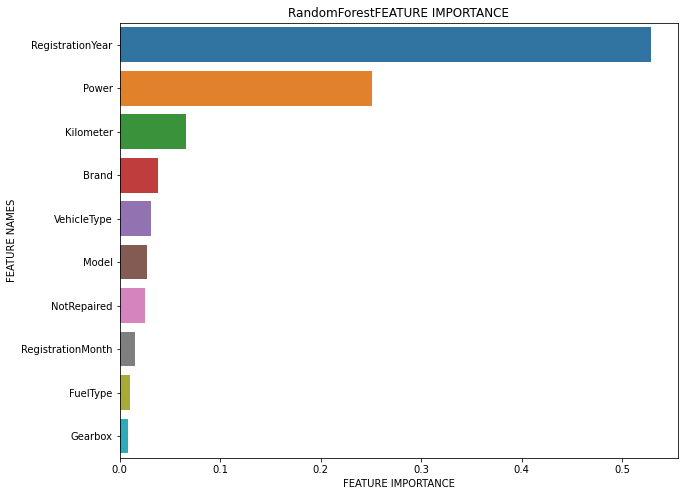

In [29]:
plot_feature_importance(model_forest_final.feature_importances_,features.columns,'RandomForest')

In [30]:
display(stats_forest)

,values
stats,
r2,0.861116
rmse_valid,345.365071
rmse_test,346.378339
time_learn,79.686816
time_predict,24.618390


## LGBoost

In [31]:
st_time_lgb = time.time()
model_lgb = lgb.LGBMRegressor()
param_dist_lgb = {"learning_rate" : [0.05,0.1],
                  "num_leaves": [300,900],
                  "n_estimators": [200],
                  'max_depth': range(1,21,10)
                 }
grid_search_lgb = GridSearchCV(model_lgb,n_jobs=-1, param_grid=param_dist_lgb, cv = 3,
                               scoring="neg_mean_squared_error", verbose=5)
grid_search_lgb.fit(features_train, target_train)
time_lgb = time.time() - st_time_lgb

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [32]:
grid_search_lgb.best_estimator_

LGBMRegressor(max_depth=11, n_estimators=200, num_leaves=300)

In [33]:
model_lgb_final = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                    importance_type='split', learning_rate=0.1, max_depth=11,
                                    min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                                    n_estimators=200, n_jobs=-1, num_leaves=300, objective=None,
                                    random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                    subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [34]:
st_time_lgb_predict = time.time()
model_lgb_final.fit(features_train, target_train)

predictions_lgb = model_lgb_final.predict(features_valid)
predictions_lgb = pd.Series(predictions_lgb)
time_lgb_predict = time.time() - st_time_lgb_predict

mse_lgb = mean_squared_error(target_valid, predictions_lgb)
rmse_lgb = mse_lgb ** 0.5
r2_lgb = r2_score(target_valid, predictions_lgb)

predictions_test_lgb = model_lgb_final.predict(features_test)
predictions_test_lgb = pd.Series(predictions_test_lgb)
mse_lgb_test = mean_squared_error(target_test, predictions_test_lgb)
rmse_lgb_test = mse_lgb_test ** 0.5

In [35]:
stats_lgb = {'stats': ['r2','rmse_valid','rmse_test','time_learn','time_predict'],
        'values': [r2_lgb,rmse_lgb,rmse_lgb_test,time_lgb,time_lgb_predict]
        }
stats_lgb = pd.DataFrame(stats_lgb).set_index('stats')


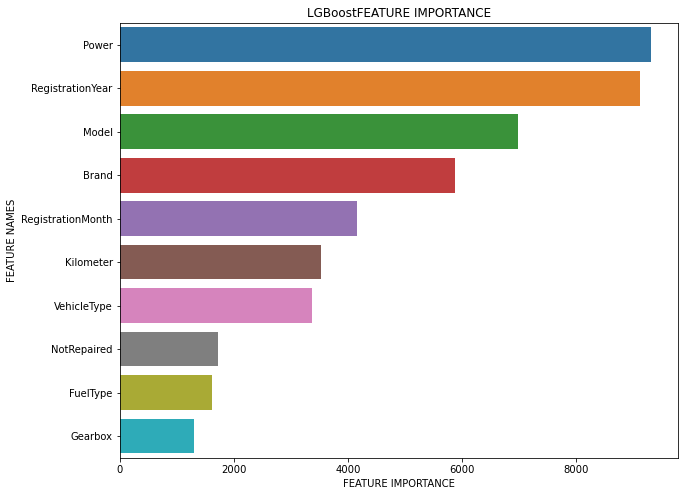

In [36]:
plot_feature_importance(model_lgb_final.feature_importances_,features.columns,'LGBoost')

In [37]:
display(stats_lgb)

,values
stats,
r2,0.875240
rmse_valid,327.333270
rmse_test,325.903371
time_learn,9.955875
time_predict,1.562044


## 2.4. CatBoost

In [38]:
st_time_cb = time.time()
model_cb = CatBoostRegressor()
model_cb_index = [0,1,2,3,4,5,6]
params_dist_cb = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'iterations': [100]}
grid_search_cb = GridSearchCV(model_cb, params_dist_cb, scoring="neg_mean_squared_error", cv = 3)
grid_search_cb.fit(features_train, target_train)
time_cb = time.time() - st_time_cb

ning: 2.54s
21:	learn: 390.7798225	total: 708ms	remaining: 2.51s
22:	learn: 388.4917500	total: 740ms	remaining: 2.48s
23:	learn: 386.6922659	total: 775ms	remaining: 2.46s
24:	learn: 384.8478172	total: 810ms	remaining: 2.43s
25:	learn: 383.5421671	total: 843ms	remaining: 2.4s
26:	learn: 382.3490588	total: 876ms	remaining: 2.37s
27:	learn: 380.6834503	total: 909ms	remaining: 2.34s
28:	learn: 378.9927780	total: 941ms	remaining: 2.3s
29:	learn: 377.6090601	total: 974ms	remaining: 2.27s
30:	learn: 376.7978865	total: 1.01s	remaining: 2.26s
31:	learn: 375.7216963	total: 1.05s	remaining: 2.23s
32:	learn: 373.8438389	total: 1.08s	remaining: 2.19s
33:	learn: 372.8073562	total: 1.11s	remaining: 2.16s
34:	learn: 372.1159591	total: 1.14s	remaining: 2.12s
35:	learn: 370.9460238	total: 1.18s	remaining: 2.09s
36:	learn: 369.6333428	total: 1.21s	remaining: 2.06s
37:	learn: 368.7876845	total: 1.24s	remaining: 2.02s
38:	learn: 368.1757424	total: 1.27s	remaining: 1.99s
39:	learn: 367.3358542	total: 1.3s	r

In [39]:
grid_search_cb.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.15}

In [40]:
model_cb_final = CatBoostRegressor(depth = 10, iterations=100, learning_rate = 0.15)

In [41]:
st_time_cb_predict = time.time()
model_cb_final.fit(features_train, target_train)

predictions_cb = model_cb_final.predict(features_valid)
predictions_cb = pd.Series(predictions_cb)
time_cb_predict = time.time() - st_time_cb_predict

mse_cb = mean_squared_error(target_valid, predictions_cb)
rmse_cb = mse_cb ** 0.5
r2_cb = r2_score(target_valid, predictions_cb)

predictions_cb_test = model_cb_final.predict(features_test)
predictions_cb_test = pd.Series(predictions_cb_test)
mse_cb_test = mean_squared_error(target_test, predictions_cb_test)
rmse_cb_test = mse_cb_test ** 0.5

0:	learn: 831.4039763	total: 35.5ms	remaining: 3.52s
1:	learn: 751.8489186	total: 71.4ms	remaining: 3.5s
2:	learn: 686.2404242	total: 107ms	remaining: 3.45s
3:	learn: 634.3364023	total: 143ms	remaining: 3.43s
4:	learn: 590.4412393	total: 179ms	remaining: 3.4s
5:	learn: 556.0113674	total: 218ms	remaining: 3.41s
6:	learn: 526.0568528	total: 255ms	remaining: 3.38s
7:	learn: 501.5400313	total: 291ms	remaining: 3.35s
8:	learn: 482.5190711	total: 327ms	remaining: 3.3s
9:	learn: 466.3073515	total: 362ms	remaining: 3.26s
10:	learn: 453.7636331	total: 398ms	remaining: 3.22s
11:	learn: 443.0930175	total: 433ms	remaining: 3.18s
12:	learn: 434.7809216	total: 471ms	remaining: 3.15s
13:	learn: 425.1301386	total: 507ms	remaining: 3.12s
14:	learn: 418.6873916	total: 544ms	remaining: 3.08s
15:	learn: 413.6506918	total: 579ms	remaining: 3.04s
16:	learn: 407.5721892	total: 614ms	remaining: 3s
17:	learn: 403.9441295	total: 650ms	remaining: 2.96s
18:	learn: 400.7715250	total: 686ms	remaining: 2.92s
19:	lea

In [42]:
stats_cb = {'stats': ['r2','rmse_valid','rmse_test','time_learn','time_predict'],
        'values': [r2_cb,rmse_cb,rmse_cb_test,time_cb,time_cb_predict]
        }
stats_cb = pd.DataFrame(stats_cb).set_index('stats')


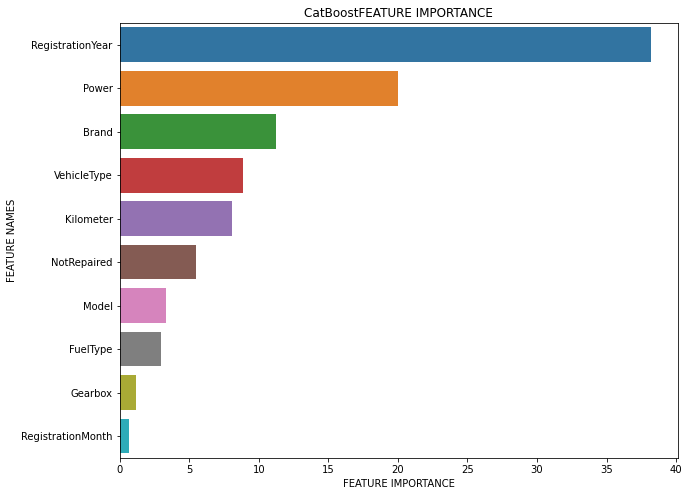

In [43]:
plot_feature_importance(model_cb_final.feature_importances_,features.columns,'CatBoost')

In [44]:
display(stats_cb)

,values
stats,
r2,0.860932
rmse_valid,345.593357
rmse_test,345.909496
time_learn,53.062096
time_predict,4.020477


## XGBoost

In [45]:
st_time_xgb = time.time()
model_xgb = xgb.XGBRegressor()
param_dist_xgb = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
                 }
grid_search_xgb = GridSearchCV(model_xgb, param_grid=param_dist_xgb, cv = 3, 
                               verbose=True, n_jobs=-1)
grid_search_xgb.fit(features_train, target_train)
time_xgb = time.time() - st_time_xgb

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[12:48:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:48:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [46]:
grid_search_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [47]:
model_xgb_final = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                   colsample_bynode=1, colsample_bytree=0.7, gamma=0,
                                   importance_type='gain', learning_rate=0.07, max_delta_step=0,
                                   max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
                                   n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
                                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
                                   subsample=0.7, verbosity=1)

In [48]:
st_time_xgb_predict = time.time()
model_xgb_final.fit(features_train, target_train)

predictions_xgb = model_xgb_final.predict(features_valid)
predictions_xgb = pd.Series(predictions_xgb)
time_xgb_predict = time.time() - st_time_xgb_predict

mse_xgb = mean_squared_error(target_valid, predictions_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(target_valid, predictions_xgb)

predictions_xgb_test = model_xgb_final.predict(features_test)
predictions_xgb_test = pd.Series(predictions_xgb_test)
mse_xgb_test = mean_squared_error(target_test, predictions_xgb_test)
rmse_xgb_test = mse_xgb_test ** 0.5

[12:48:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[12:48:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [49]:
stats_xgb = {'stats': ['r2','rmse_valid','rmse_test','time_learn','time_predict'],
        'values': [r2_xgb,rmse_xgb,rmse_xgb_test,time_xgb,time_xgb_predict]
        }
stats_xgb = pd.DataFrame(stats_xgb).set_index('stats')


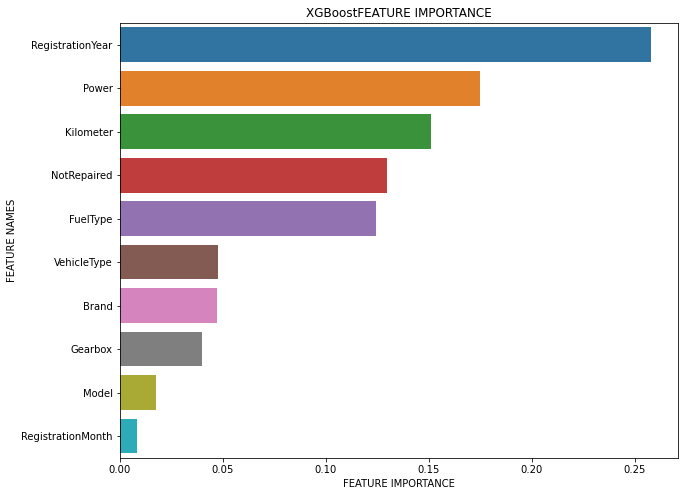

In [50]:
plot_feature_importance(model_xgb_final.feature_importances_,features.columns,'XGBoost')

In [51]:
display(stats_xgb)

,values
stats,
r2,0.872709
rmse_valid,330.636027
rmse_test,329.326773
time_learn,113.866093
time_predict,15.717360


# Final analysis

Let's analyse the results. For this task LGBoost is optimal.
   
- the best metrics has been evaluated by LGBoost, R2 = 0.87/ RMSE = 328  
- linear regression is the fastest, but with the worst scores
- pretty optimal is Catboost, it gave a bit forse result than, LGBoost or XGBoost, but was much faster than other, although it has strange and imbalaced feature importance.

,LinearRegression,RandomForestRegressor,LGBoost,CatBoost,XGBoost
stats,,,,,
r2,0.556693,0.861116,0.875240,0.860932,0.872709
rmse_valid,617.026919,345.365071,327.333270,345.593357,330.636027
rmse_test,624.883177,346.378339,325.903371,345.909496,329.326773
time_learn,0.000000,79.686816,9.955875,53.062096,113.866093
time_predict,0.000000,24.618390,1.562044,4.020477,15.717360


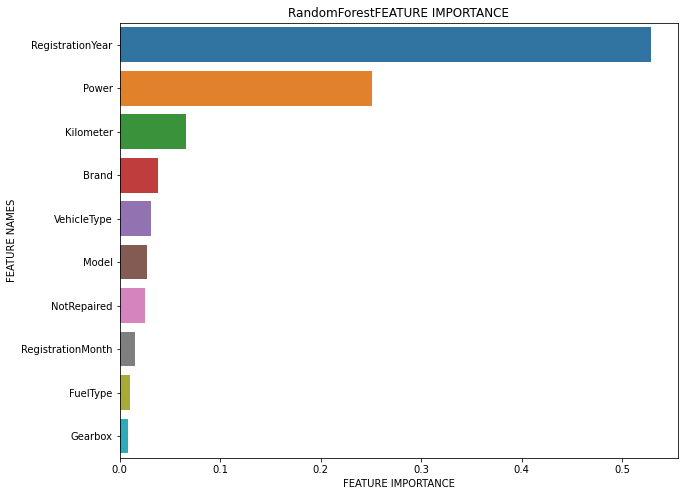

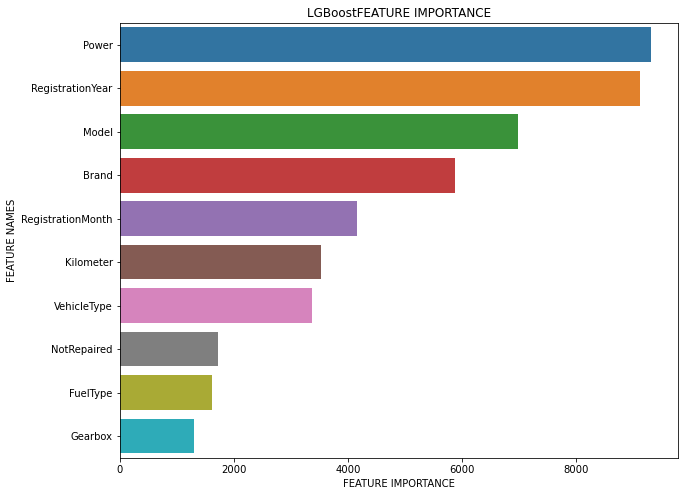

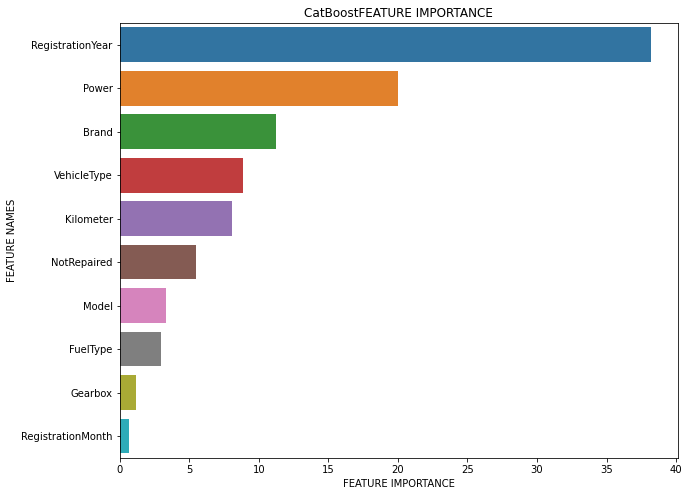

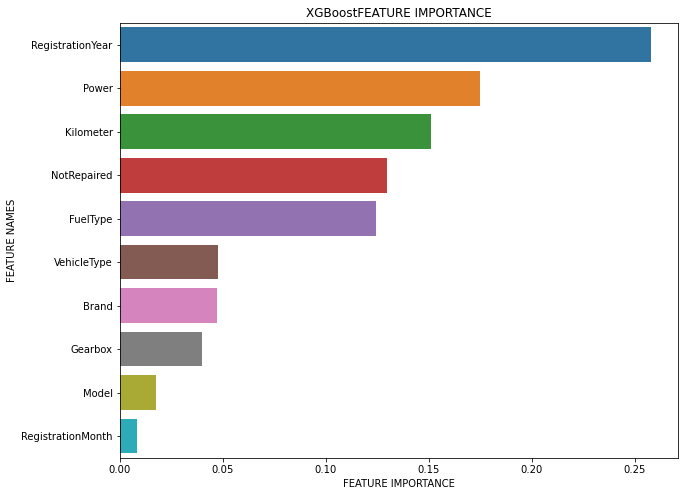

In [52]:
analysis = pd.concat([stats_lin,stats_forest,stats_lgb,stats_cb,stats_xgb], axis=1, sort=False)
analysis.columns = ['LinearRegression','RandomForestRegressor','LGBoost','CatBoost','XGBoost']
plot_feature_importance(model_forest_final.feature_importances_,features.columns,'RandomForest')
plot_feature_importance(model_lgb_final.feature_importances_,features.columns,'LGBoost')
plot_feature_importance(model_cb_final.feature_importances_,features.columns,'CatBoost')
plot_feature_importance(model_xgb_final.feature_importances_,features.columns,'XGBoost')
display(analysis)